In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import loader
%load_ext autoreload
%autoreload 2
from infid_sen_utils import get_explanation_pdt, get_exp_infid, get_exp_sens
import time

import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

# RAP
from modules.vgg import vgg16

In [2]:
# device = torch.device('cuda:5') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

### Plotting Utils

In [4]:
from matplotlib import pylab as P
from skimage import feature, transform
import matplotlib.pyplot as plt
%matplotlib inline



def ShowGrayscaleImageAxis(im, ax):
    ax.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
    ax.axis('off')
def ShowGrayscaleImageAxis2(im, ax, title=None):
    im = im.transpose(1, 2, 0)
    ax.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
    if title is not None:
        ax.set_title(title,{'fontsize': 80})
    ax.axis('off')    

def vis(expl, norm):
    n_pixel = expl.shape[-1]
    if len(expl.shape) == 4:
        expl = expl[0].transpose(1, 2, 0)
    elif len(expl.shape) == 3:
        expl = expl.transpose(1, 2, 0)
    elif len(expl.shape) == 1:
        expl = expl.reshape((n_pixel,n_pixel))
        
    if norm:
        expl = (expl - expl.mean()) / expl.std()
    return expl      
    
    
def plot(data, xi=None, cmap='RdBu_r', axis=plt, percentile=100, dilation=3.0, alpha=0.8, title = None, infid = 0,sens = 0):
    dx, dy = 0.05, 0.05
    #print(data.shape)
    xx = np.arange(0.0, data.shape[1], dx)
    yy = np.arange(0.0, data.shape[0], dy)
    xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
    extent = xmin, xmax, ymin, ymax
    cmap_xi = plt.get_cmap('Greys_r')
    cmap_xi.set_bad(alpha=0)
    overlay = None
    if xi is not None:
        # Compute edges (to overlay to heatmaps later)
        xi_greyscale = xi if len(xi.shape) == 2 else np.mean(xi, axis=-1)
        in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
        edges = feature.canny(in_image_upscaled).astype(float)
        edges[edges < 0.5] = np.nan
        edges[:5, :] = np.nan
        edges[-5:, :] = np.nan
        edges[:, :5] = np.nan
        edges[:, -5:] = np.nan
        overlay = edges

    abs_max = np.percentile(np.abs(data), percentile)
    abs_min = abs_max

    if len(data.shape) == 3:
        data = np.mean(data, 2)
    axis.imshow(data, extent=extent, interpolation='none', cmap=cmap, vmin=-abs_min, vmax=abs_max)
    if title is not None:
        axis.set_title(title+"\n infid: {:0.3f} \n sensitivity: {:0.3f}".format(infid,sens),{'fontsize': 80})
    if overlay is not None:
        axis.imshow(overlay, extent=extent, interpolation='none', cmap=cmap_xi, alpha=alpha)
    axis.axis('off')
    return axis



/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


### Explanation Untils

In [5]:
def get_expl_infid_sens(X, model, y, exp, sg_r=None, sg_N=None, given_expl=None, binary_I=False):
    s = time.time()
    sen_r = 0.2
    sen_N = 10 # can change to a larger size for better estimation of sensitivity
    X = torch.FloatTensor(X).unsqueeze(0).cuda().to(device)

    expl, pdt = get_explanation_pdt(X, model, y, exp, sg_r=sg_r, sg_N=sg_N,
                                  given_expl=given_expl, binary_I=binary_I)
    pdt = pdt.data.cpu().numpy()

    norm = np.linalg.norm(expl)
    print("[%s] Time for generating the explanation: %.2f sec"%(exp,time.time()-s))
    infid = get_exp_infid(X, model, expl, y, pdt, binary_I=binary_I, pert = 'Gaussian')
    print("[%s] Time for calculating INFD: %.2f sec"%(exp,time.time()-s))
    sens = get_exp_sens(X, model, expl,exp, y, pdt, sg_r, sg_N,sen_r,sen_N,norm,binary_I,given_expl)
        
    print("[%s] Time for calculating SENS: %.2f sec"%(exp,time.time()-s))
#     sens = 100
    return expl,infid,sens

### Prepare Model

In [6]:

# model = models.resnet18(pretrained=True)
model = models.vgg16(pretrained=True).to(device)
# for RAP
model_ = vgg16(pretrained=True).to(device).eval()

model = model.eval()

In [7]:
# Download ImageNet dataset
# !wget -P ./data https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
# Download ImageNet image samples
# !git clone https://github.com/EliSchwartz/imagenet-sample-images ./data

### Prepare Data

In [8]:


labels_path = './data/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

data_path = './data/imagenet-sample-images/'
file_list = os.listdir(data_path)
img_list = []
for file in file_list:
    if '.JPEG' in file:
        img_list.append(file)
img_list.sort()


In [9]:
# Defines transformers and normalizing functions

transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

# Load a sample image
# img_path = data_path+img_list[141]
img_path = data_path+img_list[440]
img = Image.open(img_path)
print(img_path)

transformed_img = transform(img)
input = transform_normalize(transformed_img)
input = input.cuda().unsqueeze(0).to(device)

./data/imagenet-sample-images/n02823428_beer_bottle.JPEG


In [10]:
# Predict the class of the input
model = model.to(device)
output = model(input).to(device)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')



Predicted: beer_bottle ( 0.9558026790618896 )


### Example Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Kernel_SHAP] Time for generating the explanation: 0.78 sec
[Kernel_SHAP] Time for calculating INFD: 1.51 sec
[Kernel_SHAP] Time for calculating SENS: 8.96 sec
[LIME] Time for generating the explanation: 1.08 sec
[LIME] Time for calculating INFD: 1.87 sec
[LIME] Time for calculating SENS: 11.37 sec
[IG] Time for generating the explanation: 0.33 sec
[IG] Time for calculating INFD: 1.11 sec
[IG] Time for calculating SENS: 4.22 sec
[LRP] Time for generating the explanation: 0.13 sec
[LRP] Time for calculating INFD: 0.84 sec
[LRP] Time for calculating SENS: 1.13 sec
[Grad_CAM] Time for generating the explanation: 0.02 sec
[Grad_CAM] Time for calculating INFD: 0.79 sec
[Grad_CAM] Time for calculating SENS: 1.06 sec
[RAP] Time for generating the explanation: 0.14 sec
[RAP] Time for calculating INFD: 0.86 sec
[RAP] Time for calculating SENS: 2.09 sec


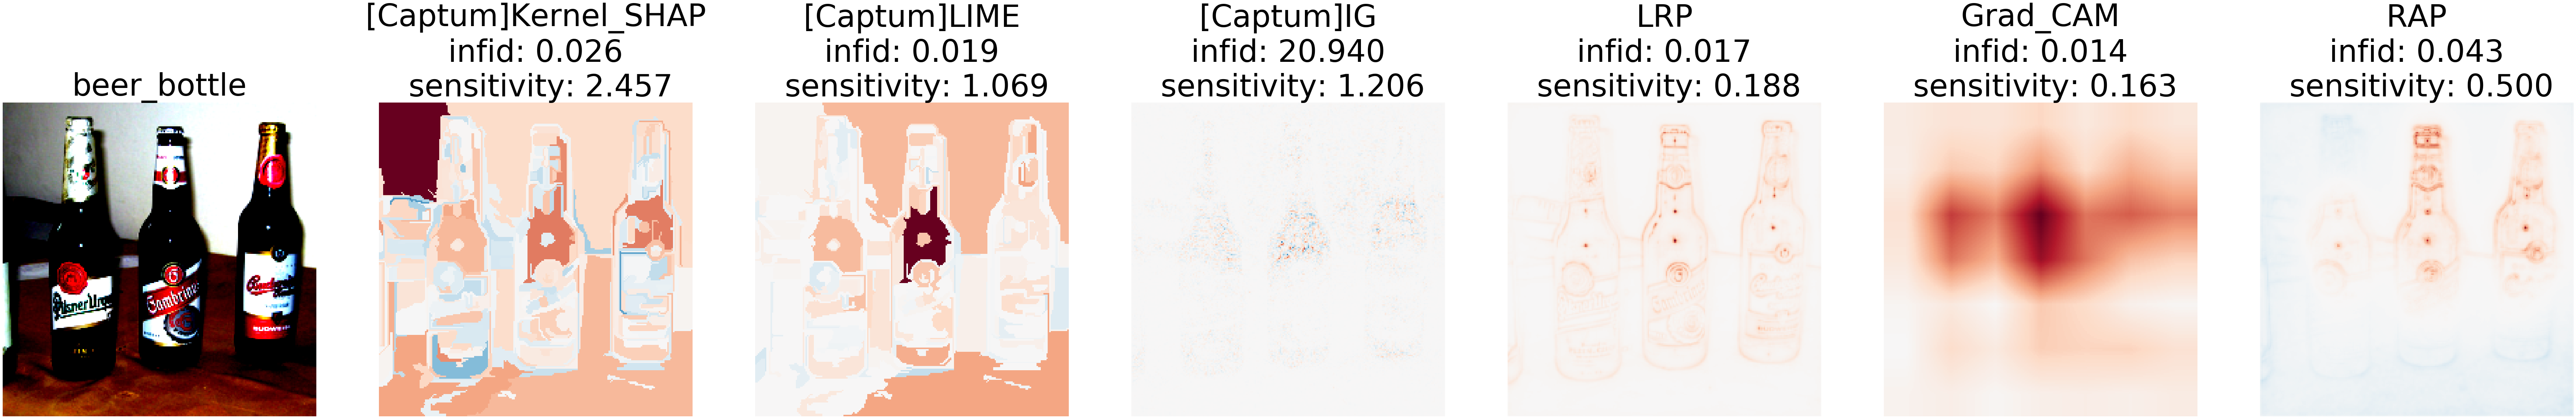

In [11]:
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

X = input.squeeze().cpu().detach().numpy()
y = pred_label_idx.item()


n_cols = 7
# fig, axes = plt.subplots(nrows=1, ncols=n_cols, figsize=(15*6, 15*2))
fig, axes = plt.subplots(nrows=1, ncols=n_cols, figsize=(20*6, 20*2))

ShowGrayscaleImageAxis2(X, ax=axes[0], title=predicted_label)

expl,infid,sens = get_expl_infid_sens(X, model, y, 'Kernel_SHAP', sg_r=0.3, sg_N=50, binary_I=False)
plot(vis(expl, False), axis=axes[1], title = '[Captum]Kernel_SHAP', infid = infid, sens = sens)
torch.cuda.empty_cache()

expl,infid,sens = get_expl_infid_sens(X, model, y, 'LIME', sg_r=0.3, sg_N=50, binary_I=False)
plot(vis(expl, False), axis=axes[2], title = '[Captum]LIME', infid = infid, sens = sens)
torch.cuda.empty_cache()


expl,infid,sens = get_expl_infid_sens(X, model, y, 'IG', sg_r=0.3, sg_N=50, binary_I=False)
plot(vis(expl, False), axis=axes[3], title = '[Captum]IG', infid = infid, sens = sens)
torch.cuda.empty_cache()

expl,infid,sens = get_expl_infid_sens(X, model, y, 'LRP', sg_r=0.3, sg_N=50, binary_I=False)
plot(vis(expl, False), axis=axes[4], title = 'LRP', infid = infid, sens = sens)
torch.cuda.empty_cache()

# expl,infid,sens = get_expl_infid_sens(X, model_, pred_label_idx, 'LRP2', sg_r=0.3, sg_N=50, binary_I=False)
# plot(vis(expl, False), axis=axes[2], title = 'LRP2', infid = infid, sens = sens)
# torch.cuda.empty_cache()


expl,infid,sens = get_expl_infid_sens(X, model, y, 'Grad_CAM', sg_r=0.3, sg_N=50, binary_I=False)
plot(vis(expl, False), axis=axes[5], title = 'Grad_CAM', infid = infid, sens = sens)
torch.cuda.empty_cache()



expl,infid,sens = get_expl_infid_sens(X, model_, pred_label_idx, 'RAP', sg_r=0.3, sg_N=50, binary_I=False)
plot(vis(expl, False), axis=axes[6], title = 'RAP', infid = infid, sens = sens)
torch.cuda.empty_cache()

plt.show()


In [ ]:
from skimage.segmentation import quickshift, slic, watershed, felzenszwalb
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from torchvision.transforms.functional import to_pil_image

# generate superpixel
X_ = X.transpose(1,2,0)

if X_.dtype != np.double:
    X_ = X_.astype(np.double)
    
fig, axes = plt.subplots(nrows=1, ncols=n_cols, figsize=(20*6, 20*2))
seg = felzenszwalb(X_, scale=250)    
axes[0].imshow(mark_boundaries(X_, seg))
axes[0].set_title('felzenszwalb',{'fontsize': 80})
seg = quickshift(X_, ratio=1, kernel_size=5, max_dist=10) # default
axes[1].imshow(mark_boundaries(X_, seg))
axes[1].set_title('quickshift',{'fontsize': 80})
seg = slic(X_, n_segments=150, compactness=10)
axes[2].imshow(mark_boundaries(X_, seg))
axes[2].set_title('slic',{'fontsize': 80})

plt.show()

In [ ]:
plt.show()